# UCI regression 

In [1]:
import jax
import optax
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

import datagen
from functools import partial
from bayes_opt import BayesianOptimization
from jax.sharding import PositionalSharding
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import gauss_filter as gfilter
from rebayes_mini.methods import robust_filter as rfilter
from rebayes_mini.methods import generalised_bayes_filter as gbfilter

In [2]:
devices = jax.devices()
sharding = PositionalSharding(devices)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%config InlineBackend.figure_format = "retina"

In [49]:
uci = datagen.UCIDatasets("./data")

dataset_name = "concrete"

X_collection= []
y_collection = []
ix_clean_collection = []

n_runs = 56
v_error = 50
seed_init = 314
for i in range(n_runs):
    # data = uci.sample_one_sided_noisy_dataset(dataset_name, p_error=0.05, seed=seed_init + i, v_error=v_error)
    data = uci.sample_noisy_covariates(dataset_name, p_error=0.1, seed=seed_init + i, v_error=v_error)
    X = data["X"]
    y = data["y"]
    ix_clean = ~data["err_where"].any(axis=1).astype(bool)
    
    X_collection.append(X)
    y_collection.append(y)
    ix_clean_collection.append(ix_clean)

In [50]:
X_collection = jnp.array(X_collection)
y_collection = jnp.array(y_collection)
mask_clean = np.array(ix_clean_collection).T

In [51]:
X_collection = jax.device_put(X_collection, sharding.reshape(-1, 1, 1))
y_collection = jax.device_put(y_collection, sharding.reshape(-1, 1))

In [52]:
p_error = 0.1
X = np.zeros((10, 5))
err_where = np.random.choice(2, size=(10, 5), p=[1 - p_error, p_error])
ix_where = np.where(err_where)

X_subset = X[ix_where].copy()

In [53]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Setup

In [54]:
lr = 0.1
Q = 0.0

def callback_fn(bel, bel_pred, y, x, applyfn):
    yhat = applyfn(bel_pred.mean, x[None])
    return yhat

In [55]:
y, X = y_collection[0], X_collection[0]
ix_clean = ix_clean_collection[0]

In [56]:
Q = 0.0
observation_covariance = 1.0

In [57]:
key = jax.random.PRNGKey(314)
model = MLP()
params_init = model.init(key, X[:1])

In [58]:
X_collection.shape

(56, 928, 8)

## EKF

In [59]:
def filter_ekf(log_lr):
    lr = np.exp(log_lr)
    agent = gfilter.ExtendedKalmanFilter(
        lambda x: x,
        model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance  * jnp.eye(1),
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.vobs_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(log_lr):
    res = -jnp.power(filter_ekf(log_lr)[0] - y, 2).mean()
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [60]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 2         | -0.7574   | -2.057    |
| 12        | -0.7517   | -2.148    |
| 14        | -0.745    | -2.336    |
| 15        | -0.7372   | -2.431    |
| 16        | -0.7309   | -2.528    |
| 17        | -0.7238   | -2.626    |
| 20        | -0.7215   | -2.855    |
| 22        | -0.7193   | -3.071    |
CPU times: user 7min 35s, sys: 2min 44s, total: 10min 19s
Wall time: 2min 4s


In [61]:
%%time

lr = np.exp(bo.max["params"]["log_lr"])
agent = gfilter.ExtendedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=Q,
    observation_covariance=1.0 * jnp.eye(1),
)

bel_init = agent.init_bel(params_init, cov=lr)

callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))
res = scanfn(bel_init, y_collection, X_collection, callback)

res = jax.block_until_ready(res)
state_final_collection, yhat_collection_ekf = res
yhat_collection_ekf = yhat_collection_ekf.squeeze()

CPU times: user 22.9 s, sys: 1.07 s, total: 24 s
Wall time: 1min 9s


In [62]:
err_collection_ekf = pd.DataFrame(np.power(y_collection - yhat_collection_ekf, 2).T)

## WLF-IMQ

### Hparam choice

In [63]:
def filter_imqf(soft_threshold, log_lr):
    lr = np.exp(log_lr)
    agent = gbfilter.IMQFilter(
        model.apply, dynamics_covariance=Q,
        observation_covariance=observation_covariance,
        soft_threshold=soft_threshold
    )

    bel_init = agent.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent.link_fn)
    bel_imq, yhat_pp = agent.scan(bel_init, y, X, callback_fn=callback)
    out = (agent, bel_imq)
    return yhat_pp.squeeze(), out

def opt_step(soft_threshold, log_lr):
    # res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_imqf(soft_threshold, log_lr)[0] - y, 2).mean()
    
    if np.isnan(res):
        res = -1e+6
    
    return res

In [64]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "soft_threshold": (1e-6, 15),
        "log_lr": (-5, 0),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | soft_t... |
-------------------------------------------------
| 2         | -0.7626   | -3.675    | 11.75     |
| 10        | -0.754    | -2.076    | 8.718     |
| 11        | -0.722    | -2.943    | 9.151     |
| 22        | -0.7216   | -2.992    | 13.52     |
CPU times: user 7min 46s, sys: 2min 45s, total: 10min 31s
Wall time: 2min 7s


### Eval

In [65]:
soft_threshold = bo.max["params"]["soft_threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = gbfilter.IMQFilter(
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0,
    soft_threshold=soft_threshold
)

In [66]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.link_fn)
_, yhat_collection_wlf = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_wlf = jax.block_until_ready(yhat_collection_wlf.squeeze())

CPU times: user 22.2 s, sys: 916 ms, total: 23.1 s
Wall time: 1min 8s


In [67]:
err_collection_wlf = pd.DataFrame(np.power(y_collection - yhat_collection_wlf, 2).T)

## IW-based EKF
(Agamenoni 2012)

### Hparam choice

In [68]:
def filter_rkf(noise_scaling, log_lr):
    lr = np.exp(log_lr)
    agent_rekf = rfilter.ExtendedRobustKalmanFilter(
        lambda x: x, model.apply, dynamics_covariance=Q,
        prior_observation_covariance=observation_covariance * jnp.eye(1),
        noise_scaling=noise_scaling,
        n_inner=1
    )
    
    bel_init = agent_rekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_rekf.vobs_fn)
    bel_rekf, yhat_pp = agent_rekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_rekf, bel_rekf)
    
    return yhat_pp.squeeze(), out

In [69]:
def opt_step(noise_scaling, log_lr):
    # res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2)[ix_clean].mean()
    res = -jnp.power(filter_rkf(noise_scaling, log_lr)[0] - y, 2).mean()
    if np.isnan(res):
        res = -1e+6
    
    return res

In [70]:
%%time
bo = BayesianOptimization(
    opt_step,
    pbounds={
        "noise_scaling": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | noise_... |
-------------------------------------------------
| 2         | -0.7856   | -3.675    | 11.75     |
| 12        | -0.7499   | -2.904    | 9.571     |
| 19        | -0.7482   | -3.05     | 15.0      |
CPU times: user 3min 14s, sys: 2min 38s, total: 5min 53s
Wall time: 44.3 s


### Eval

In [71]:
noise_scaling = bo.max["params"]["noise_scaling"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedRobustKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    prior_observation_covariance=1.0 * jnp.eye(1),
    n_inner=1,
    noise_scaling=noise_scaling,
)

In [72]:
bel_init = agent.init_bel(params_init, cov=lr)
callback = partial(callback_fn, applyfn=agent.vobs_fn)
_, yhat_collection_ann1 = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ann1 = yhat_collection_ann1.squeeze()

In [73]:
err_collection_ann1 = pd.DataFrame(np.power(y_collection - yhat_collection_ann1, 2).T)

## Mahalanobis-based EKF
(Ting 2007)

### Hparam section

In [74]:
def filter_mah_ekf(threshold, log_lr):
    lr = np.exp(log_lr)
    agent_mekf = rfilter.ExtendedThresholdedKalmanFilter(
        lambda x: x, model.apply,
        dynamics_covariance=Q,
        observation_covariance=observation_covariance * jnp.eye(1),
        threshold=threshold
    )
    
    bel_init = agent_mekf.init_bel(params_init, cov=lr)
    callback = partial(callback_fn, applyfn=agent_mekf.vobs_fn)
    
    bel_mekf, yhat_pp = agent_mekf.scan(bel_init, y, X, callback_fn=callback)
    out = (agent_mekf, bel_mekf)
    return yhat_pp.squeeze(), out

In [75]:
%%time
bo = BayesianOptimization(
    # lambda threshold, log_lr: -jnp.power(filter_mah_ekf(threshold, log_lr)[0] - y, 2)[ix_clean].mean(),
    lambda threshold, log_lr: -jnp.power(filter_mah_ekf(threshold, log_lr)[0] - y, 2).mean(),
    pbounds={
        "threshold": (1e-6, 15),
        "log_lr": (-5, 0)
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   | threshold |
-------------------------------------------------
| 2         | -0.7622   | -3.675    | 11.75     |
| 14        | -0.7596   | -3.622    | 9.966     |
| 15        | -0.7528   | -3.278    | 8.894     |
| 16        | -0.7401   | -2.473    | 9.817     |
| 17        | -0.722    | -2.612    | 11.05     |
CPU times: user 7min 53s, sys: 2min 56s, total: 10min 49s
Wall time: 2min 10s


### Eval

In [76]:
threshold = bo.max["params"]["threshold"]
lr = np.exp(bo.max["params"]["log_lr"])

agent = rfilter.ExtendedThresholdedKalmanFilter(
    lambda x: x,
    model.apply,
    dynamics_covariance=0.0,
    observation_covariance=1.0 * jnp.eye(1),
    threshold=threshold,
)

In [77]:
%%time
bel_init = agent.init_bel(params_init, cov=lr)
bel_init = jax.device_put(bel_init, sharding.replicate(0))
callback = partial(callback_fn, applyfn=agent.vobs_fn)
scanfn = jax.jit(jax.vmap(agent.scan, in_axes=(None, 0, 0, None)), static_argnames=("callback_fn",))

_, yhat_collection_mekf = scanfn(bel_init, y_collection, X_collection, callback)
yhat_collection_mekf = jax.block_until_ready(yhat_collection_mekf)
yhat_collection_mekf = yhat_collection_mekf.squeeze()

CPU times: user 19.7 s, sys: 980 ms, total: 20.7 s
Wall time: 1min 7s


In [78]:
err_collection_mekf = pd.DataFrame(np.power(y_collection - yhat_collection_mekf, 2).T)

## Online SGD

In [79]:
def lossfn(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    return jnp.sum(counter * (y - yhat) ** 2) / counter.sum()

def filter_ogd(log_lr, n_inner):
    lr = np.exp(log_lr)
    n_inner = int(n_inner)
    
    agent = replay_sgd.FifoSGD(
        model.apply,
        lossfn,
        optax.adam(lr),
        buffer_size=1,
        dim_features=X.shape[-1],
        dim_output=1,
        n_inner=n_inner,
    )

    callback = partial(callback_fn, applyfn=model.apply)

    bel_init = agent.init_bel(params_init)
    bel_final, yhat_pp = agent.scan(bel_init, y, X, callback)
    out = (agent, bel_final)
    yhat_pp = yhat_pp.squeeze()

    return yhat_pp.squeeze(), out

In [80]:
%%time
bo = BayesianOptimization(
    # lambda threshold, log_lr: -jnp.power(filter_mah_ekf(threshold, log_lr)[0] - y, 2)[ix_clean].mean(),
    lambda log_lr, n_inner: -jnp.power(filter_ogd(log_lr, n_inner)[0] - y, 2).mean(),
    pbounds={
        "log_lr": (-5, 0),
        "n_inner": (1, 10),
    },
    verbose=1,
    random_state=314,
    allow_duplicate_points=True
)

bo.maximize(init_points=10)

|   iter    |  target   |  log_lr   |  n_inner  |
-------------------------------------------------
| 2         | -189.1    | -3.675    | 8.049     |
| 7         | -90.39    | -4.389    | 4.474     |
| 9         | -10.61    | -4.65     | 6.698     |
| 13        | -3.659    | -4.939    | 8.961     |
CPU times: user 2min 45s, sys: 2min 45s, total: 5min 31s
Wall time: 22.9 s


In [81]:
lr = jnp.exp(bo.max["params"]["log_lr"])
n_inner = int(bo.max["params"]["n_inner"])

agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn,
    optax.adam(lr),
    buffer_size=1,
    dim_features=X.shape[-1],
    dim_output=1,
    n_inner=n_inner
)

callback = partial(callback_fn, applyfn=model.apply)

bel_init = agent.init_bel(params_init)
state_final, yhat = agent.scan(bel_init, y, X, callback)
yhat = yhat.squeeze()

errs = (y - yhat)
jnp.sqrt(jnp.power(errs, 2).mean())

Array(1.9360497, dtype=float32)

In [82]:
%%time
_, yhat_collection_ogd = jax.vmap(agent.scan, in_axes=(None, 0, 0, None))(bel_init, y_collection, X_collection, callback)
yhat_collection_ogd = jax.block_until_ready(yhat_collection_ogd)
yhat_collection_ogd = yhat_collection_ogd.squeeze()

CPU times: user 1.24 s, sys: 54.4 ms, total: 1.3 s
Wall time: 953 ms


In [83]:
err_collection_ogd  = pd.DataFrame(np.power(y_collection - yhat_collection_ogd, 2).T)

# Results

In [84]:
import seaborn as sns

In [85]:
pd.set_option("display.float_format", lambda x: format(x, "0.4f"))

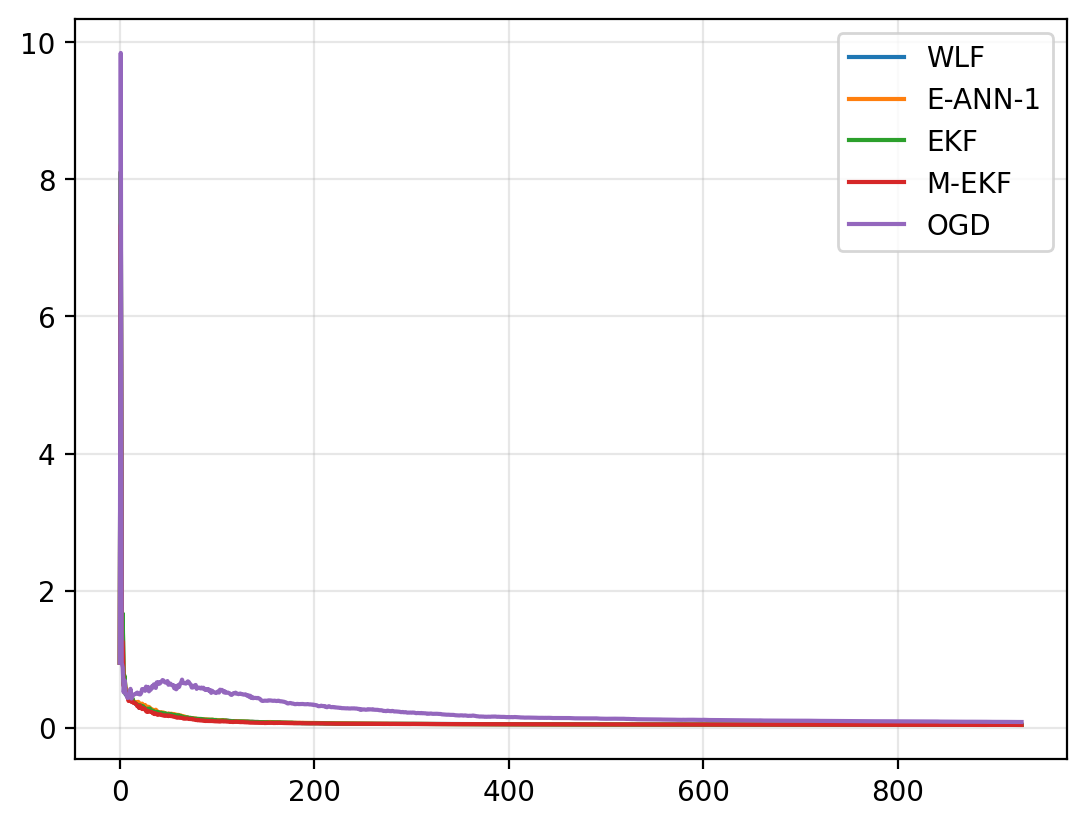

In [86]:
err_collection_wlf.expanding().median().median(axis=1).plot(label="WLF")
err_collection_ann1.expanding().median().median(axis=1).plot(label="E-ANN-1")
err_collection_ekf.expanding().median().median(axis=1).plot(label="EKF")
err_collection_mekf.expanding().median().median(axis=1).plot(label="M-EKF")
err_collection_ogd.expanding().median().median(axis=1).plot(label="OGD")
# plt.yscale("log")
plt.legend()
plt.grid(alpha=0.3)

In [87]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "EKF": err_collection_ekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "OGD": err_collection_ogd.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "M-EKF": err_collection_mekf.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
    "E-ANN-1": err_collection_ann1.mul(mask_clean)[10:].sum(axis=0) / mask_clean[10:].sum(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,M-EKF,E-ANN-1
count,56.0000,56.0000,56.0000,56.0000,56.0000
mean,0.0526,0.0524,0.0711,0.0485,0.0513
std,0.0062,0.0063,0.0093,0.0061,0.0060
min,0.0407,0.0403,0.0567,0.0367,0.0394
25%,0.0483,0.0482,0.0644,0.0447,0.0473
50%,0.0513,0.0505,0.0695,0.0473,0.0494
75%,0.0552,0.0552,0.0750,0.0514,0.0538
max,0.0751,0.0748,0.0940,0.0690,0.0722


In [93]:
df_results = pd.DataFrame({
    "WLF-IMQ": err_collection_wlf.mean(axis=0),
    "EKF": err_collection_ekf.mean(axis=0),
    "OGD": err_collection_ogd.mean(axis=0),
    "M-EKF": err_collection_mekf.mean(axis=0),
    "E-ANN-1": err_collection_ann1.mean(axis=0),
})

df_results.describe()

,WLF-IMQ,EKF,OGD,M-EKF,E-ANN-1
count,56.0000,56.0000,56.0000,56.0000,56.0000
mean,0.7750,0.7688,5.7870,0.8403,0.7957
std,0.1289,0.1259,3.3619,0.2089,0.1246
min,0.4845,0.4886,2.4679,0.4863,0.5218
25%,0.6689,0.6673,3.7613,0.6963,0.6972
50%,0.7604,0.7543,4.7205,0.7822,0.7799
75%,0.8822,0.8731,6.0483,1.0134,0.9123
max,0.9941,0.9875,18.4060,1.6313,1.0328


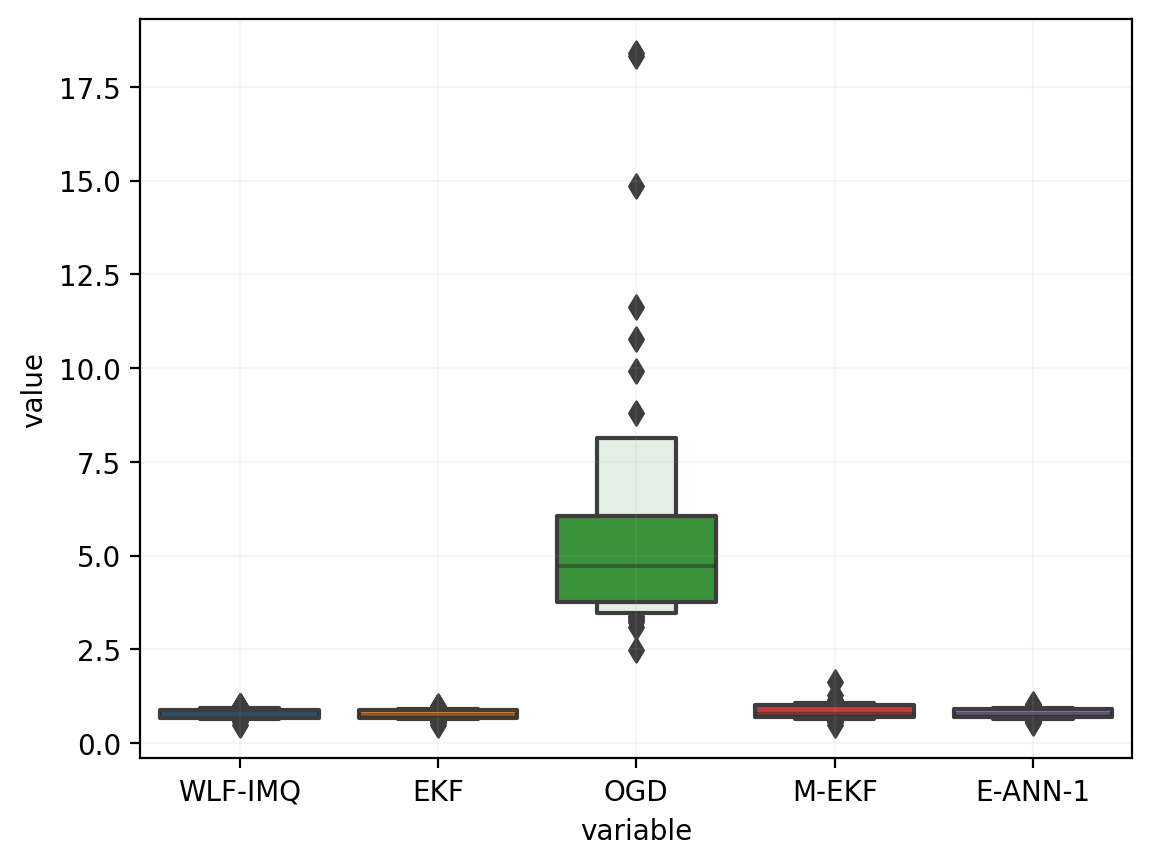

In [89]:
sns.boxenplot(
    x="variable",
    y="value",
    data=df_results.melt().query("value < 30"),
)
plt.grid(alpha=0.1)

In [90]:
err_collection = {
    "methods": {
        "WLF-IMQ": err_collection_wlf,
        "EKF": err_collection_ekf,
        "OGD": err_collection_ogd,
        "M-EKF": err_collection_mekf,
        "E-ANN-1": err_collection_ann1
    },
    "config": {
        "mask-clean": mask_clean
    }
}

In [91]:
import pickle

In [92]:
with open(f"./results/{dataset_name}.pkl", "wb") as f:
    pickle.dump(err_collection, f)